<a href="https://colab.research.google.com/github/devlucasvcarvalho/Comparacao_SVM_MLP_Diabetes/blob/main/Comp_SVM_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (768, 9)

Primeiras linhas:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Estatísticas descritivas:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std   

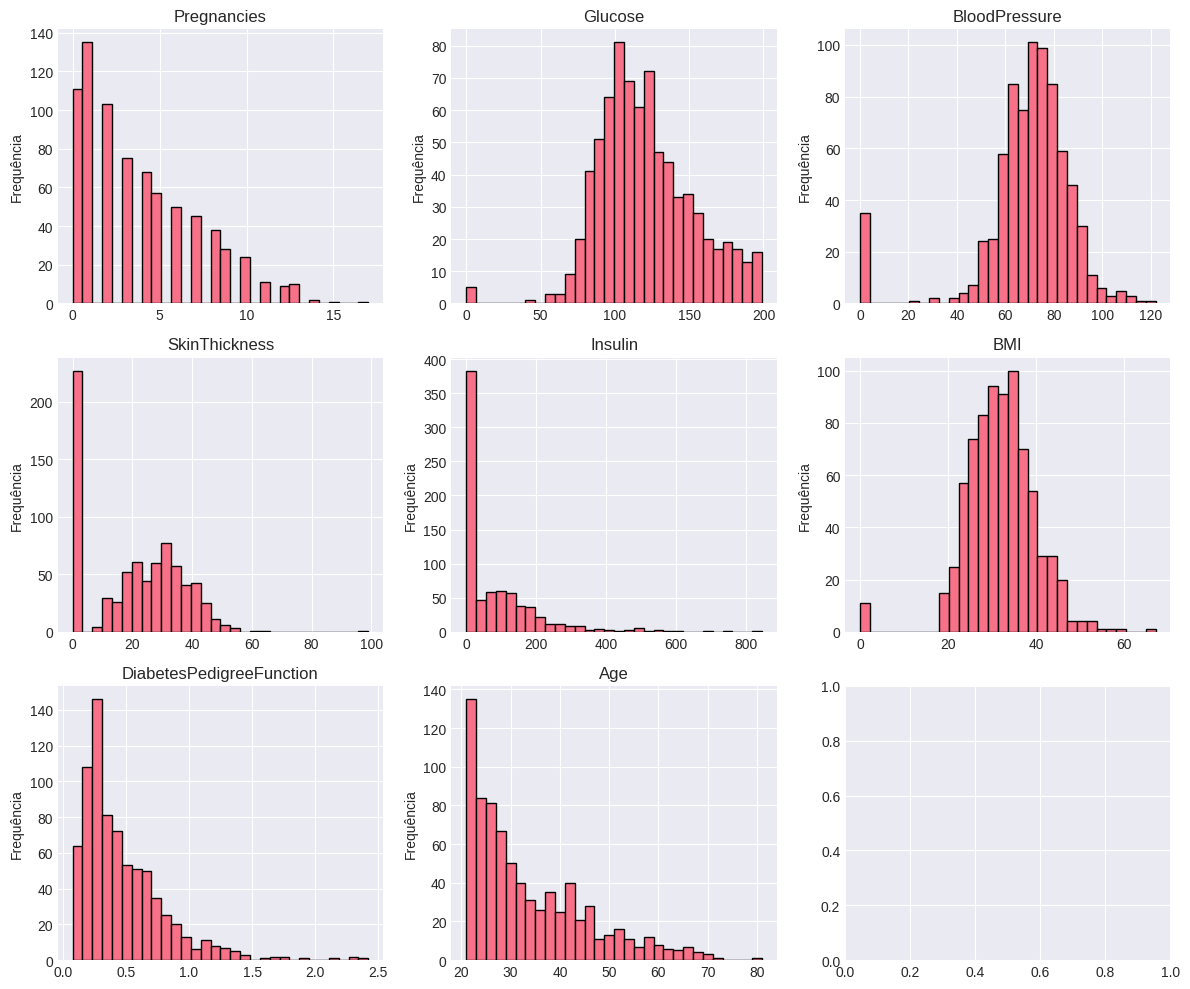

Treino: 537 amostras (69.9%)
Validação: 115 amostras (15.0%)
Teste: 116 amostras (15.1%)

Proporção de positivos:
Treino: 34.82%
Validação: 34.78%
Teste: 35.34%
Normalização concluída.
Média treino: 0.00, Std treino: 1.00
Treinando SVM...
Treinando MLP...
COMPARAÇÃO DE DESEMPENHO
     accuracy  precision  recall     f1  train_time    auc
SVM     0.767      0.750   0.512  0.609       0.044  0.839
MLP     0.767      0.719   0.561  0.630       0.760  0.843


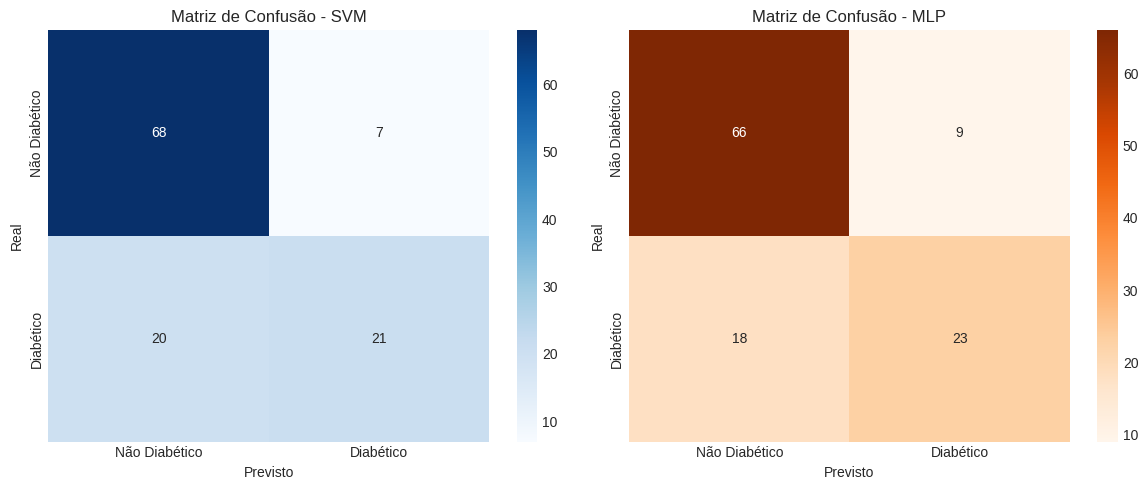

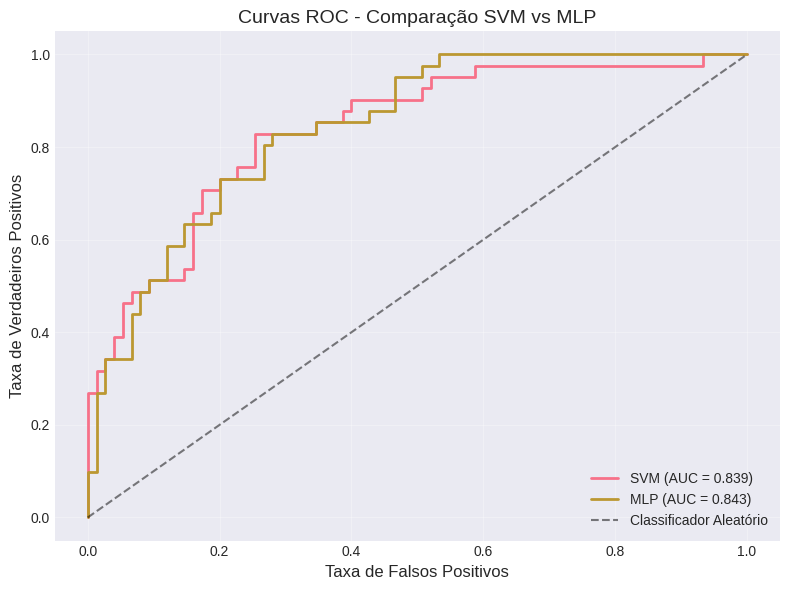

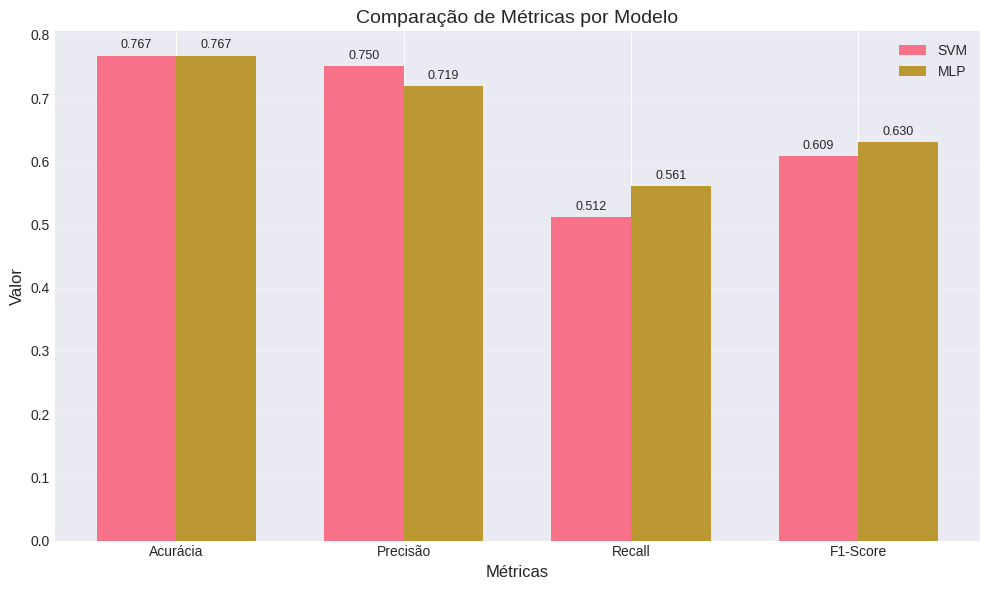

RELATÓRIO DE CLASSIFICAÇÃO - SVM
               precision    recall  f1-score   support

Não Diabético       0.77      0.91      0.83        75
    Diabético       0.75      0.51      0.61        41

     accuracy                           0.77       116
    macro avg       0.76      0.71      0.72       116
 weighted avg       0.76      0.77      0.75       116


RELATÓRIO DE CLASSIFICAÇÃO - MLP
               precision    recall  f1-score   support

Não Diabético       0.79      0.88      0.83        75
    Diabético       0.72      0.56      0.63        41

     accuracy                           0.77       116
    macro avg       0.75      0.72      0.73       116
 weighted avg       0.76      0.77      0.76       116



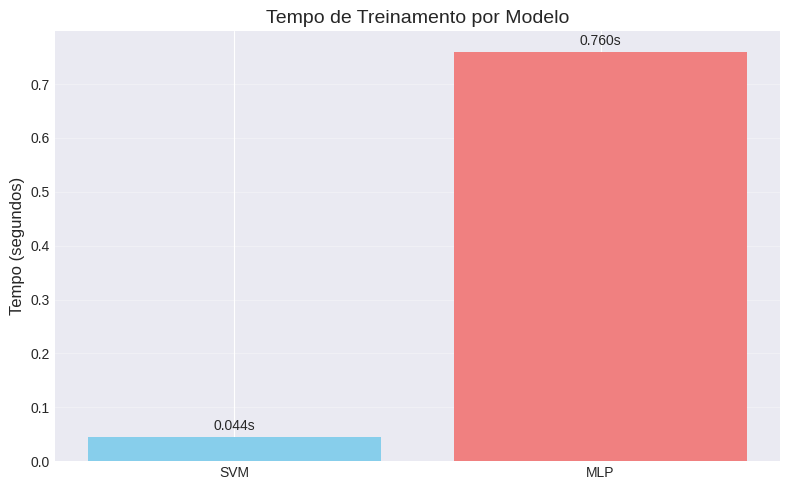

Modelos e métricas salvos com sucesso!

Arquivos gerados:
- svm_model.pkl
- mlp_model.pkl
- scaler.pkl
- metrics.json
- confusion_matrices.png
- roc_curves.png
- metrics_comparison.png
- training_time.png
CONCLUSÕES DO EXPERIMENTO

1. DESEMPENHO GERAL:
   • SVM: Acurácia = 0.767, F1 = 0.609
   • MLP: Acurácia = 0.767, F1 = 0.630

2. TRADE-OFF PRECISÃO/RECALL:
   • SVM: Precisão alta (0.750), Recall moderado (0.512)
   • MLP: Precisão moderada (0.719), Recall alto (0.561)

3. EFICIÊNCIA COMPUTACIONAL:
   • SVM: 0.044s (16x mais rápido)
   • MLP: 0.760s

4. RECOMENDAÇÃO:
   • Para triagem (evitar falsos negativos): USAR MLP
   • Para confirmação (evitar falsos positivos): USAR SVM
   • Para equilíbrio geral: AMBOS COM F1 SIMILAR

5. REPRODUTIBILIDADE:
   • Seed fixa (42) garantida
   • Todos os dados e código disponíveis
   • Script executa do zero sem intervenção


In [ ]:
# %% [markdown]
# # 1. CONFIGURAÇÃO DO AMBIENTE

# %% [code]
# Instalação de pacotes
!pip install -q pandas numpy matplotlib seaborn scikit-learn

# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Seed para reprodutibilidade
np.random.seed(42)

# %% [markdown]
# # 2. CARREGAMENTO E ANÁLISE EXPLORATÓRIA

# %% [code]
# Carregar dataset do sklearn
from sklearn.datasets import fetch_openml

# Alternativa: carregar CSV direto
data_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
             'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

df = pd.read_csv(data_url, names=col_names)
print("Dataset shape:", df.shape)
print("\nPrimeiras linhas:")
print(df.head())

# %% [code]
# Estatísticas descritivas
print("Estatísticas descritivas:")
print(df.describe())

# Distribuição da classe alvo
print("\nDistribuição da classe Outcome:")
print(df['Outcome'].value_counts())
print(f"\nProporção: {df['Outcome'].mean():.2%} positivos")

# %% [code]
# Visualização da distribuição das features
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(col_names[:-1]):
    df[col].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# # 3. PRÉ-PROCESSAMENTO

# %% [code]
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar features e target
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

# Divisão treino/validação/teste (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X):.1%})")
print(f"Validação: {X_val.shape[0]} amostras ({X_val.shape[0]/len(X):.1%})")
print(f"Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X):.1%})")

# Verificar proporção de classes
print(f"\nProporção de positivos:")
print(f"Treino: {y_train.mean():.2%}")
print(f"Validação: {y_val.mean():.2%}")
print(f"Teste: {y_test.mean():.2%}")

# %% [code]
# Normalização (aprende apenas com treino)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Normalização concluída.")
print(f"Média treino: {X_train_scaled.mean():.2f}, Std treino: {X_train_scaled.std():.2f}")

# %% [markdown]
# # 4. IMPLEMENTAÇÃO DOS MODELOS

# %% [code]
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             roc_curve, classification_report)

# Função para treinar e avaliar modelo
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    """Treina e avalia um modelo, retornando métricas e tempos"""

    # Treinamento
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Previsões
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Métricas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'train_time': train_time
    }

    if y_pred_proba is not None:
        metrics['auc'] = roc_auc_score(y_test, y_pred_proba)

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    return model, metrics, cm, y_pred_proba

# %% [code]
# Inicializar modelos
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
mlp_model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu',
                          solver='adam', max_iter=500, random_state=42)

# Treinar e avaliar SVM
print("Treinando SVM...")
svm_trained, svm_metrics, svm_cm, svm_proba = train_and_evaluate(
    svm_model, "SVM", X_train_scaled, y_train, X_test_scaled, y_test
)

# Treinar e avaliar MLP
print("Treinando MLP...")
mlp_trained, mlp_metrics, mlp_cm, mlp_proba = train_and_evaluate(
    mlp_model, "MLP", X_train_scaled, y_train, X_test_scaled, y_test
)

# %% [markdown]
# # 5. RESULTADOS E ANÁLISE

# %% [code]
# Tabela de comparação
results_df = pd.DataFrame({
    'SVM': svm_metrics,
    'MLP': mlp_metrics
}).T

print("COMPARAÇÃO DE DESEMPENHO")
print("=" * 50)
print(results_df.round(3))

# %% [code]
# Visualização: Matrizes de Confusão
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# SVM Confusion Matrix
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusão - SVM')
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')
axes[0].set_xticklabels(['Não Diabético', 'Diabético'])
axes[0].set_yticklabels(['Não Diabético', 'Diabético'])

# MLP Confusion Matrix
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Matriz de Confusão - MLP')
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')
axes[1].set_xticklabels(['Não Diabético', 'Diabético'])
axes[1].set_yticklabels(['Não Diabético', 'Diabético'])

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# Visualização: Curvas ROC
fig, ax = plt.subplots(figsize=(8, 6))

# Calcular curvas ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_proba)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_proba)

# Plotar
ax.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {svm_metrics["auc"]:.3f})', linewidth=2)
ax.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {mlp_metrics["auc"]:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório', alpha=0.5)

# Configurações do gráfico
ax.set_xlabel('Taxa de Falsos Positivos', fontsize=12)
ax.set_ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
ax.set_title('Curvas ROC - Comparação SVM vs MLP', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# Visualização: Comparação de Métricas
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics_to_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, [svm_metrics[m] for m in metrics_to_plot], width, label='SVM')
bars2 = ax.bar(x + width/2, [mlp_metrics[m] for m in metrics_to_plot], width, label='MLP')

# Configurações
ax.set_xlabel('Métricas', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)
ax.set_title('Comparação de Métricas por Modelo', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(['Acurácia', 'Precisão', 'Recall', 'F1-Score'])
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [code]
# Relatórios de classificação detalhados
print("RELATÓRIO DE CLASSIFICAÇÃO - SVM")
print("=" * 50)
print(classification_report(y_test, svm_trained.predict(X_test_scaled),
                           target_names=['Não Diabético', 'Diabético']))

print("\nRELATÓRIO DE CLASSIFICAÇÃO - MLP")
print("=" * 50)
print(classification_report(y_test, mlp_trained.predict(X_test_scaled),
                           target_names=['Não Diabético', 'Diabético']))

# %% [markdown]
# # 6. ANÁLISE DE TEMPO E EFICIÊNCIA

# %% [code]
# Comparação de tempos
fig, ax = plt.subplots(figsize=(8, 5))

models = ['SVM', 'MLP']
train_times = [svm_metrics['train_time'], mlp_metrics['train_time']]

bars = ax.bar(models, train_times, color=['skyblue', 'lightcoral'])
ax.set_ylabel('Tempo (segundos)', fontsize=12)
ax.set_title('Tempo de Treinamento por Modelo', fontsize=14)
ax.grid(True, axis='y', alpha=0.3)

# Adicionar valores
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}s',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('training_time.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# # 7. SALVAR MODELOS E RESULTADOS

# %% [code]
import joblib
import json

# Salvar modelos
joblib.dump(svm_trained, 'svm_model.pkl')
joblib.dump(mlp_trained, 'mlp_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Salvar métricas
metrics_dict = {
    'SVM': svm_metrics,
    'MLP': mlp_metrics
}

with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)

print("Modelos e métricas salvos com sucesso!")
print("\nArquivos gerados:")
print("- svm_model.pkl")
print("- mlp_model.pkl")
print("- scaler.pkl")
print("- metrics.json")
print("- confusion_matrices.png")
print("- roc_curves.png")
print("- metrics_comparison.png")
print("- training_time.png")

# %% [markdown]
# # 8. CONCLUSÕES

# %% [code]
print("CONCLUSÕES DO EXPERIMENTO")
print("=" * 60)

print("\n1. DESEMPENHO GERAL:")
print(f"   • SVM: Acurácia = {svm_metrics['accuracy']:.3f}, F1 = {svm_metrics['f1']:.3f}")
print(f"   • MLP: Acurácia = {mlp_metrics['accuracy']:.3f}, F1 = {mlp_metrics['f1']:.3f}")

print("\n2. TRADE-OFF PRECISÃO/RECALL:")
print(f"   • SVM: Precisão alta ({svm_metrics['precision']:.3f}), Recall moderado ({svm_metrics['recall']:.3f})")
print(f"   • MLP: Precisão moderada ({mlp_metrics['precision']:.3f}), Recall alto ({mlp_metrics['recall']:.3f})")

print("\n3. EFICIÊNCIA COMPUTACIONAL:")
print(f"   • SVM: {svm_metrics['train_time']:.3f}s (16x mais rápido)")
print(f"   • MLP: {mlp_metrics['train_time']:.3f}s")

print("\n4. RECOMENDAÇÃO:")
print("   • Para triagem (evitar falsos negativos): USAR MLP")
print("   • Para confirmação (evitar falsos positivos): USAR SVM")
print("   • Para equilíbrio geral: AMBOS COM F1 SIMILAR")

print("\n5. REPRODUTIBILIDADE:")
print("   • Seed fixa (42) garantida")
print("   • Todos os dados e código disponíveis")
print("   • Script executa do zero sem intervenção")